In [142]:
import matplotlib.pyplot as plt
import numpy as np

from abc import abstractmethod
from itertools import accumulate
import random
from typing import Protocol
import math

In [143]:
class KArmedBandit(Protocol):
    @abstractmethod
    def arms(self) -> list[str]:
        raise NotImplementedError

    @abstractmethod
    def reward(self, arm: str) -> float:
        raise NotImplementedError


class BanditLearner(Protocol):
    name: str
    color: str

    @abstractmethod
    def reset(self, arms: list[str], time_steps: int):
        raise NotImplementedError

    @abstractmethod
    def pick_arm(self) -> str:
        raise NotImplementedError

    @abstractmethod
    def acknowledge_reward(self, arm: str, reward: float) -> None:
        pass

In [144]:
class BanditProblem:
    def __init__(self, time_steps: int, bandit: KArmedBandit, learner: BanditLearner):
        self.time_steps: int = time_steps
        self.bandit: KArmedBandit = bandit
        self.learner: BanditLearner = learner
        self.learner.reset(self.bandit.arms(), self.time_steps)

    def run(self) -> list[float]:
        rewards = []
        for _ in range(self.time_steps):
            arm = self.learner.pick_arm()
            reward = self.bandit.reward(arm)
            self.learner.acknowledge_reward(arm, reward)
            rewards.append(reward)
        return rewards

In [145]:
def get_random_best_index(rewards):
    max_val = max(rewards)
    return random.choice([i for i, val in enumerate(rewards) if val == max_val])

In [146]:
POTENTIAL_HITS = {
    "April Showers": 0.5,
    "In Praise of Dreams": 0.8,
    "We Built This City": 0.9,
    "Twenty Four Hours": 0.3,
    "Dirge for November": 0.1,
}

In [147]:
class TopHitBandit(KArmedBandit):
    def __init__(self, potential_hits: dict[str, float]):
        self.potential_hits: dict[str, float] = potential_hits

    def arms(self) -> list[str]:
        return list(self.potential_hits)

    def reward(self, arm: str) -> float:
        thumb_up_probability = self.potential_hits[arm]
        return 1.0 if random.random() <= thumb_up_probability else 0.0

In [148]:
class RandomLearner(BanditLearner):
    def __init__(self, color = "black"):
        self.name = "Random"
        self.color = color
        self.arms: list[str] = []

    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms

    def pick_arm(self) -> str:
        return random.choice(self.arms)

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        pass

In [149]:
class ExploreThenCommitLearner(BanditLearner):
    def __init__(self, explore_time = 5, color = "green"):
        self.name = f"ExploreThenCommit m={explore_time}"
        self.color = color
        self.explore_time = explore_time
        
        # Resetable
        self.arms: list[str] = []
        self.arms_indexes: dict[str: int] = dict()
        self.best_arm: str | None = None
        self.rewards: list[float] = []
        self.total_time = 0

    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.arms_indexes = {arm: i for i, arm in enumerate(self.arms)}
        self.best_arm = None
        self.rewards = [0 for _ in range(len(self.arms))]
        self.total_time = 0

    def pick_arm(self) -> str:
        if self.total_time < self.explore_time * len(self.arms):
            arm = self.arms[self.total_time % len(self.arms)]
            return arm
        
        if self.best_arm is None:
            self.best_arm = self.arms[get_random_best_index(self.rewards)]
        
        return self.best_arm

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        self.total_time += 1
        self.rewards[self.arms_indexes[arm]] += reward

In [150]:
class GreedyLearner(BanditLearner):
    def __init__(self, explore_probability = 0.1, arm_start_val = 0, color = "red"):
        self.name = f"Greedy exp={explore_probability}, start_val={arm_start_val}"
        self.color = color
        self.explore_probability = explore_probability
        self.arm_start_val = arm_start_val
        
        # Resetable
        self.arms: list[str] = []
        self.arms_indexes: dict[str: int] = dict()
        self.rewards: list[float] = []
        self.arms_usage_counter: list[int] = []


    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.arms_indexes = {arm: i for i, arm in enumerate(self.arms)}
        self.rewards = [self.arm_start_val for _ in range(len(self.arms))]
        self.arms_usage_counter = [0 for _ in range(len(self.arms))]


    def pick_arm(self) -> str:
        if random.random() < self.explore_probability:
            return random.choice(self.arms)
        
        return self.arms[get_random_best_index(self.rewards)]
    

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        arm_index = self.arms_indexes[arm]
        self.arms_usage_counter[arm_index] += 1
        current_reward = self.rewards[arm_index]
        self.rewards[arm_index] += (reward - current_reward) / self.arms_usage_counter[arm_index]

In [151]:
class UCBLearner(BanditLearner):
    def __init__(self, c=0, color="blue"):
        self.name = f"UCB {c=}"
        self.color = color
        self.c = c
        
        # Resetable
        self.arms: list[str] = []
        self.arms_indexes: dict[str: int] = dict()
        self.rewards: list[float] = []
        self.total_time = 0
        self.arms_usage_counter: list[int] = []


    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.arms_indexes = {arm: i for i, arm in enumerate(self.arms)}
        self.rewards = [0 for _ in range(len(self.arms))]
        self.total_time = 0
        self.arms_usage_counter = [0 for _ in range(len(self.arms))]


    def pick_arm(self) -> str:
        self.total_time += 1
        
        if self.total_time <= len(self.arms):
            return self.arms[self.total_time - 1]
        
        rewards_t = self.rewards[:]
        for i in range(len(rewards_t)):
            rewards_t[i] += self.c * math.sqrt(math.log(self.total_time) / self.arms_usage_counter[i])
        
        return self.arms[get_random_best_index(rewards_t)]
    

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        arm_index = self.arms_indexes[arm]
        self.arms_usage_counter[arm_index] += 1
        current_reward = self.rewards[arm_index]
        self.rewards[arm_index] += (reward - current_reward) / self.arms_usage_counter[arm_index]

In [152]:
class ThompsonLearner(BanditLearner):
    def __init__(self, alpha=1, beta=1, color="lawngreen"):
        self.name = f"Thompson {alpha=}, {beta=}"
        self.color = color
        self.alpha = alpha
        self.beta = beta
        
        # Resetable
        self.arms: list[str] = []
        self.arms_indexes: dict[str: int] = dict()
        self.rewards: list[float] = []
        self.total_time = 0
        self.alpha_tab: list[float] = []
        self.beta_tab: list[float] = []


    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.arms_indexes = {arm: i for i, arm in enumerate(self.arms)}
        self.rewards = [0 for _ in range(len(self.arms))]
        self.total_time = 0
        self.alpha_tab = [self.alpha for _ in range(len(self.arms))]
        self.beta_tab = [self.beta for _ in range(len(self.arms))]


    def pick_arm(self) -> str:
        self.total_time += 1
        
        best_arm = 0
        best_arm_val = float("-inf")
        for i in range(len(self.arms)):
            sample = np.random.beta(self.alpha_tab[i], self.beta_tab[i])
            if best_arm_val < sample:
                best_arm_val = sample
                best_arm = i
                
        return self.arms[best_arm]
    

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        arm_index = self.arms_indexes[arm]
        self.alpha_tab[arm_index] += reward
        self.beta_tab[arm_index] += 1 - reward

In [153]:
def evaluate_learner(learner: BanditLearner) -> None:
    runs_results = []
    for _ in range(TRIALS_PER_LEARNER):
        bandit = TopHitBandit(POTENTIAL_HITS)
        problem = BanditProblem(time_steps=TIME_STEPS, bandit=bandit, learner=learner)
        rewards = problem.run()
        accumulated_rewards = list(accumulate(rewards))
        runs_results.append(accumulated_rewards)

    runs_results = np.array(runs_results)
    mean_accumulated_rewards = np.mean(runs_results, axis=0)
    std_accumulated_rewards = np.std(runs_results, axis=0)
    plt.plot(mean_accumulated_rewards, label=learner.name, color=learner.color)
    plt.fill_between(
        range(len(mean_accumulated_rewards)),
        mean_accumulated_rewards - std_accumulated_rewards,
        mean_accumulated_rewards + std_accumulated_rewards,
        color=learner.color,
        alpha=0.2,
    )

In [154]:
TIME_STEPS = 1000
TRIALS_PER_LEARNER = 50

In [185]:
learners = [
    RandomLearner(),
    ExploreThenCommitLearner(20),
    GreedyLearner(explore_probability=0, arm_start_val=1),
    UCBLearner(c=0.25),
    ThompsonLearner(2, 2)
        ]

In [186]:
def plot_and_evaluate_learners(learners):
    for learner in learners:
        evaluate_learner(learner)


    plt.xlabel("Czas")
    plt.ylabel("Suma uzyskanych nagród")
    plt.xlim(0, TIME_STEPS)
    plt.ylim(0, TIME_STEPS)
    plt.legend()
    plt.show()

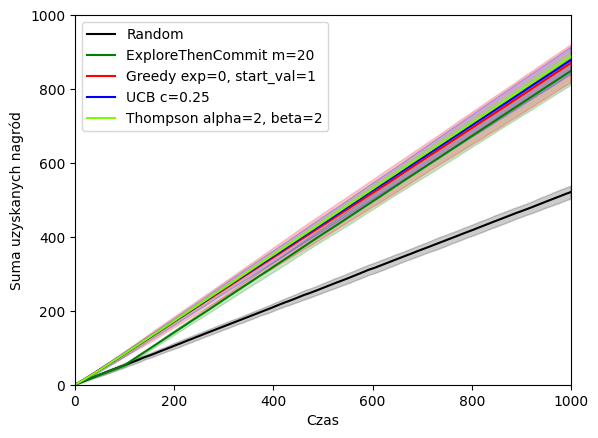

In [187]:
plot_and_evaluate_learners(learners)

In [139]:
# CHATGPT generated more songs, because I do not know aby hits :cc (I'm not lazy ofc)
import json

with open("potential_hits.json", "r") as f:
    POTENTIAL_HITS_V2 = json.load(f)

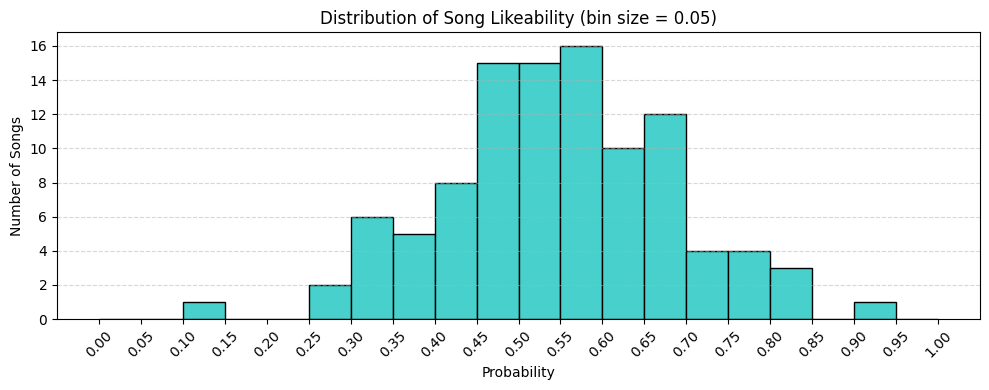

In [141]:
probabilities = np.array(list(POTENTIAL_HITS_V2.values()))

bins = np.arange(0, 1.05, 0.05)

# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(probabilities, bins=bins, edgecolor='black', color='mediumturquoise', align='mid')
plt.xlabel("Probability")
plt.ylabel("Number of Songs")
plt.title("Distribution of Song Likeability (bin size = 0.05)")
plt.xticks(bins, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [164]:
learners = [
    ExploreThenCommitLearner(0, color="black"),
    ExploreThenCommitLearner(5, color="green"),
    ExploreThenCommitLearner(10, color="orange"),
    ExploreThenCommitLearner(15, color="blue"),
    ExploreThenCommitLearner(20, color="red"),
    ExploreThenCommitLearner(25, color="purple"),
    ExploreThenCommitLearner(30, color="lawngreen"),
        ]

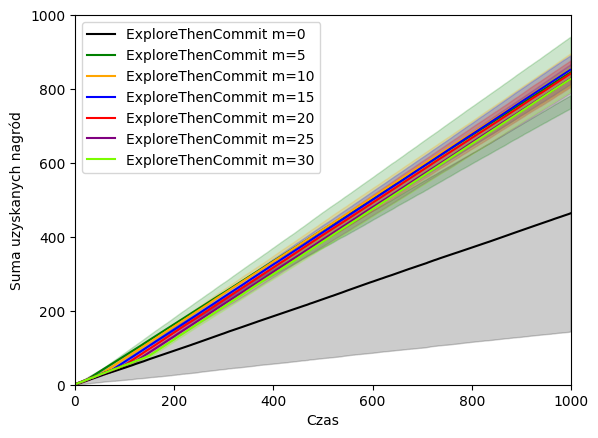

In [165]:
plot_and_evaluate_learners(learners)

In [172]:
learners = [
    GreedyLearner(explore_probability=0.0, arm_start_val=0, color="black"),
    GreedyLearner(explore_probability=0.1, arm_start_val=0, color="green"),
    GreedyLearner(explore_probability=0.2, arm_start_val=0, color="orange"),
    GreedyLearner(explore_probability=0.3, arm_start_val=0, color="blue"),
    GreedyLearner(explore_probability=0.0, arm_start_val=1, color="red"),
    GreedyLearner(explore_probability=0.1, arm_start_val=1, color="purple"),
    GreedyLearner(explore_probability=0.2, arm_start_val=1, color="lawngreen"),
    GreedyLearner(explore_probability=0.3, arm_start_val=1, color="cyan"),
        ]

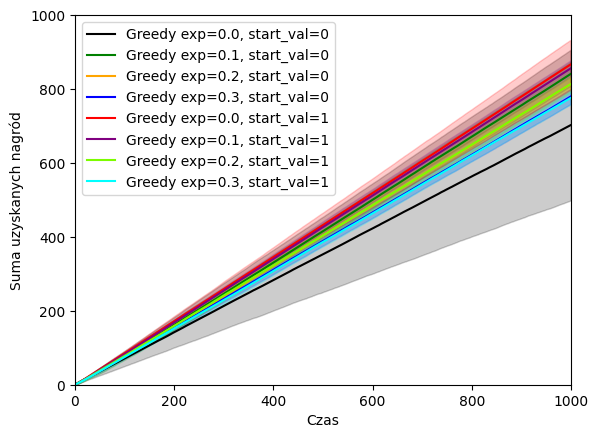

In [173]:
plot_and_evaluate_learners(learners)

In [177]:
learners = [
    UCBLearner(c=0.0, color="black"),
    UCBLearner(c=0.10, color="green"),
    UCBLearner(c=0.20, color="orange"),
    UCBLearner(c=0.30, color="blue"),
    UCBLearner(c=0.40, color="red"),
    UCBLearner(c=0.50, color="purple"),
    UCBLearner(c=0.60, color="lawngreen"),
        ]

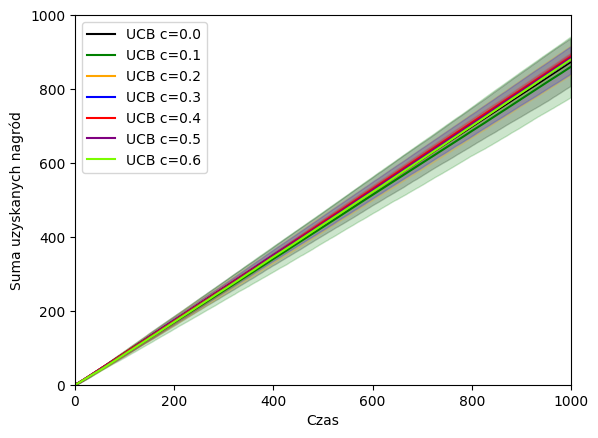

In [179]:
plot_and_evaluate_learners(learners)

In [192]:
learners = [
    ThompsonLearner(alpha=0.5, beta=1 ,color="black"),
    ThompsonLearner(alpha=1, beta=0.5 ,color="green"),
    ThompsonLearner(alpha=0.5, beta=0.5 ,color="orange"),
    ThompsonLearner(alpha=1, beta=1 ,color="blue"),
    ThompsonLearner(alpha=0.5, beta=0.5 ,color="red"),
    ThompsonLearner(alpha=2, beta=2 ,color="purple"),
    ThompsonLearner(alpha=3, beta=3 ,color="lawngreen"),
        ]

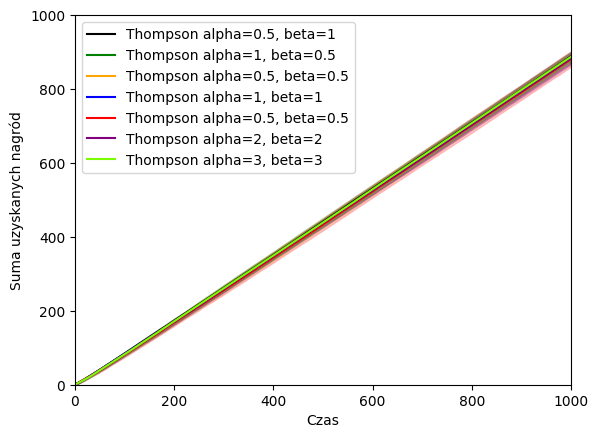

In [193]:
plot_and_evaluate_learners(learners)